# Artifact 4: Discrete Allocation Analysis

In [1]:
# pip install -U yfinance

In [2]:
# pip install -U PyPortfolioOpt

In [3]:
#imports
import yfinance as yf
import pandas as pd
import numpy as np
import cvxpy as cp
import time
from pypfopt import expected_returns, risk_models, EfficientFrontier, plotting
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
import matplotlib.pyplot as plt
from pypfopt.plotting import plot_efficient_frontier

In [4]:
stocks = ["AAPL", "MSFT", "GOOG", "NVDA"]
# stocks = ["AAPL", "MSFT", "GOOG", "AMZN", "META", "TSLA", "NVDA", "AMD", "BABA", "GM", "HUBS", "SPOT", "JPM", "UNH", "V", "JNJ", "PG", "NFLX", "DIS", "UBER"]
data = yf.download(stocks, start="2013-01-01", end="2023-01-01")['Adj Close']

[*********************100%%**********************]  4 of 4 completed


In [5]:
data.to_csv('stock_prices.csv')

In [6]:
df = pd.read_csv('stock_prices.csv')
df_numeric = df.drop(columns=['Date'])
df_numeric.head()

,AAPL,GOOG,MSFT,NVDA
0,16.747725,18.013729,22.532846,2.935841
1,16.536327,18.024191,22.230997,2.938148
2,16.075714,18.380356,21.814936,3.035087
3,15.981149,18.300158,21.774141,2.947380
4,16.024166,18.264042,21.659924,2.882756


In [7]:
mu = expected_returns.capm_return(df_numeric)
S = risk_models.semicovariance(df_numeric, benchmark=((1.0392**(1/252))-1))

ef = EfficientFrontier(mu, S)

raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
# ef.save_weights_to_file("weights.csv")  # saves to file
print(cleaned_weights)

OrderedDict([('AAPL', 0.18186), ('GOOG', 0.20478), ('MSFT', 0.29053), ('NVDA', 0.32283)])


In [8]:
ef.portfolio_performance(verbose=True)

Expected annual return: 31.6%
Annual volatility: 19.8%
Sharpe Ratio: 1.49


(0.3158431268106099, 0.1979918049625268, 1.4942190504632402)

/opt/conda/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


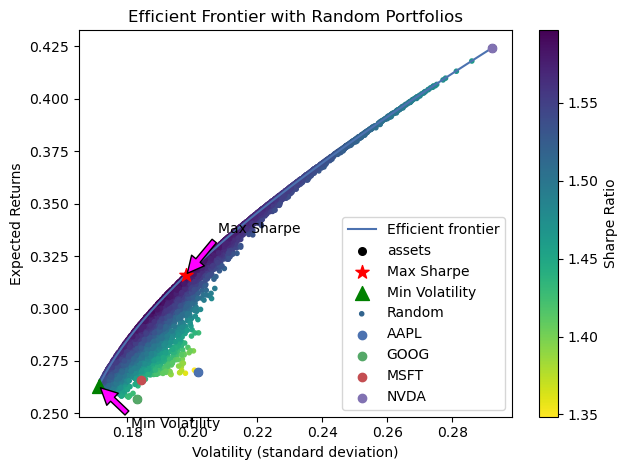

In [9]:
ef_for_plotting = EfficientFrontier(mu, S)
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef_for_plotting, ax=ax, show_assets=True)  # Change to True to show assets

# Max Sharpe Portfolio
ef_max_sharpe = EfficientFrontier(mu, S)
weights = ef_max_sharpe.max_sharpe()
ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe", zorder=3)

# Min Volatility Portfolio 
ef_min_vol = EfficientFrontier(mu, S)
weights_min_vol = ef_min_vol.min_volatility()
ret_min_vol, std_min_vol, _ = ef_min_vol.portfolio_performance()
ax.scatter(std_min_vol, ret_min_vol, marker="^", s=100, c="g", label="Min Volatility", zorder=3)

# Monte Carlo Simulations to generate random portfolios
n_samples = 10000
rand_weights = np.random.dirichlet(alpha=np.ones(ef_for_plotting.n_assets), size=n_samples)
rand_rets = rand_weights.dot(mu)
rand_stds = np.sqrt(np.diag(rand_weights @ S @ rand_weights.T))
sharpes = rand_rets / rand_stds
scatter = ax.scatter(rand_stds, rand_rets, c=sharpes, cmap="viridis_r", marker='.', label="Random")

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Sharpe Ratio")

for ticker in df_numeric.columns:
    ticker_volatility = np.sqrt(S.loc[ticker, ticker])
    ticker_return = mu[ticker]
    ax.scatter(ticker_volatility, ticker_return, marker='o', label=ticker, zorder=2)

ax.annotate('Max Sharpe', xy=(std_tangent, ret_tangent), xytext=(std_tangent+0.01, ret_tangent+0.02),
            arrowprops=dict(facecolor='magenta', shrink=0.05))
ax.annotate('Min Volatility', xy=(std_min_vol, ret_min_vol), xytext=(std_min_vol+0.01, ret_min_vol-0.02),
            arrowprops=dict(facecolor='magenta', shrink=0.05))

ax.legend()
ax.set_title("Efficient Frontier with Random Portfolios")
ax.set_xlabel('Volatility (standard deviation)')
ax.set_ylabel('Expected Returns')
plt.tight_layout()
plt.show()

In [10]:
latest_prices = get_latest_prices(df_numeric)
print(latest_prices)

AAPL    129.043121
GOOG     88.730003
MSFT    237.273453
NVDA    146.068329
Name: 2517, dtype: float64


## Problem of interest begins over here:

In [11]:
da = DiscreteAllocation(raw_weights, latest_prices, total_portfolio_value=100)
allocation, leftover = da.greedy_portfolio()
print("Discrete allocation:", allocation)
print("Funds remaining: ${:.2f}".format(leftover))

Discrete allocation: {'GOOG': 1}
Funds remaining: $11.27


/opt/conda/lib/python3.11/site-packages/pypfopt/discrete_allocation.py:212: RuntimeWarning: invalid value encountered in divide
  current_weights /= current_weights.sum()


In [12]:
da = DiscreteAllocation(raw_weights, latest_prices, total_portfolio_value=1000)
allocation, leftover = da.greedy_portfolio()
print("Discrete allocation:", allocation)
print("Funds remaining: ${:.2f}".format(leftover))

Discrete allocation: {'NVDA': 2, 'MSFT': 1, 'GOOG': 2, 'AAPL': 2}
Funds remaining: $35.04


In [13]:
da = DiscreteAllocation(raw_weights, latest_prices, total_portfolio_value=10000)
allocation, leftover = da.greedy_portfolio()
print("Discrete allocation:", allocation)
print("Funds remaining: ${:.2f}".format(leftover))

Discrete allocation: {'NVDA': 22, 'MSFT': 12, 'GOOG': 23, 'AAPL': 14}
Funds remaining: $91.82


Making a layman observation, we can see that the change in the recommended discrete allocation of stocks is not in conjunction with the change in the total portfoilio value. One would imagine that if the total portfolio value changes by a 1000% from \$1000 to \$10000, number of NVDA stocks recommended would also go up to 20 stocks and adhere to the same percentage change. But that's not what happens over here.  

Hence, I'm interested in understanding why is that? What is the mathematics behind greedy algorithms for portfolio optimization? Why did the developers of PyPortFolio Opt deem greedy algorithm to be their recommended option for discrete allocation? Hence, I will compare this with a simple manual allocation method, and integer programming. We will set two criteria's of comparison: computational speed and amount of money left. Ideally, we want the allocation algorithm to be computationally fast, and utilize all of the portfolio value in investments.

### Option 1: Manual Method

Let's establish the manual method. We'll simply assign the weights as percentage portions of each stock and find the dollar amounts of them against the total portfolio value. Then we'll divide the dollar amount share of each stock with their latest prices, and round down the quotient to value a conservative mindset.

In [14]:
cleaned_weights

OrderedDict([('AAPL', 0.18186),
             ('GOOG', 0.20478),
             ('MSFT', 0.29053),
             ('NVDA', 0.32283)])

In [15]:
latest_prices

AAPL    129.043121
GOOG     88.730003
MSFT    237.273453
NVDA    146.068329
Name: 2517, dtype: float64

In [16]:
total_portfolio_value = 1000

In [17]:
funds_remaining = total_portfolio_value
discrete_allocation = {}
for stock, weight in cleaned_weights.items():
    money_allocated = total_portfolio_value * weight
    number_of_shares = np.floor(money_allocated / latest_prices[stock])
    discrete_allocation[stock] = int(number_of_shares)
    funds_remaining -= number_of_shares * latest_prices[stock]

print("Discrete allocation:", discrete_allocation)
print("Funds remaining: ${:.2f}".format(funds_remaining))

Discrete allocation: {'AAPL': 1, 'GOOG': 2, 'MSFT': 1, 'NVDA': 2}
Funds remaining: $164.09


In [18]:
def manual_allocation(cleaned_weights, latest_prices, total_portfolio_value):
    start_time = time.time()

    funds_remaining = total_portfolio_value
    discrete_allocation = {}
    
    for stock, weight in cleaned_weights.items():
        money_allocated = total_portfolio_value * weight
        number_of_shares = np.floor(money_allocated / latest_prices[stock])
        discrete_allocation[stock] = int(number_of_shares)
        funds_remaining -= number_of_shares * latest_prices[stock]
    
    computation_time = time.time() - start_time
    return discrete_allocation, funds_remaining, computation_time

manual_allocation(cleaned_weights, latest_prices, 100)

({'AAPL': 0, 'GOOG': 0, 'MSFT': 0, 'NVDA': 0}, 100.0, 7.677078247070312e-05)

In [19]:
manual_allocation(cleaned_weights, latest_prices, 1000)

({'AAPL': 1, 'GOOG': 2, 'MSFT': 1, 'NVDA': 2},
 164.08676147460938,
 8.487701416015625e-05)

In [20]:
manual_allocation(cleaned_weights, latest_prices, 10000)

({'AAPL': 14, 'GOOG': 23, 'MSFT': 12, 'NVDA': 22},
 91.82155609130905,
 9.703636169433594e-05)

We can already see a huge difference in the results of our manual method and PyPortfolioOpt's `greedy_portfolio()`. Although our manual method seems pretty fast. It lacks the ability to use up all the allotted portfolio funds. The manual method struggles with lower portfolio values (in comparison to the chosen stock prices), but concludes with the same allocation for $10,000 portofolio value as the `greedy_portfolio()`.

### Option 2: Integer Progamming Method

Integer programming is a form of mathematical optimization where some or all of the variables are restricted to be integers. In portfolio optimization, it is used to determine the best way to allocate a given amount of capital across a selection of assets while adhering to a desired set of asset weights and ensuring that the number of shares of each asset is an integer.$

The mathematical problem is set up as follows:

- `T ∈ ℝ` is the total dollar value to be allocated.
- `p ∈ ℝⁿ` is the array of latest prices for each asset.
- `w ∈ ℝⁿ` is the set of target weights for each asset, representing the proportion of the total portfolio value that should be allocated to each asset.
- `x ∈ ℤⁿ` is the integer allocation for each asset, representing the number of shares to purchase.
- `r ∈ ℝ` is the remaining unallocated value after purchasing shares, ensuring that the total spent does not exceed `T`.

The objective in integer programming is to minimize the sum of `r`, which represents any unspent budget, and the deviation from the target allocation measured by the L1 norm `||wT - x ⊙ p||₁`. Here, `⊙` denotes element-wise multiplication.

The optimization problem is formulated as:

Minimize the objective:
$$
\text{minimize} \quad r + \left\| wT - x \circ p \right\|_1
$$

Subject to the constraint:
$$
\text{subject to} \quad r + x \cdot p = T
$$

This optimization ensures that we get as close as possible to the desired allocation `wT` in terms of dollar amount while spending the entire budget `T` or as close to it as possible.

Now that we have setup our integer programming program to match our ideal requirements. We can go aheads and test it out.

In [21]:
T = 1000

In [22]:
# Convert latest_prices to a numpy array
p = latest_prices.values

In [23]:
# Convert cleaned_weights to a numpy array using the same order as latest_prices
w = np.array([cleaned_weights[ticker] for ticker in latest_prices.index])

In [24]:
x = cp.Variable(len(p), integer=True)
r = cp.Variable()

In [25]:
objective = cp.Minimize(r + cp.norm(w * T - cp.multiply(x, p), 1))

In [26]:
constraints = [r + cp.sum(cp.multiply(x, p)) == T, x >= 0, r >= 0]

In [27]:
problem = cp.Problem(objective, constraints)
problem.solve(solver=cp.ECOS_BB)
print("Allocation:", x.value)
print("Funds remaining: ", r.value)

Allocation: [2.         2.00000001 1.00000001 2.        ]
Funds remaining:  35.043638240599655


Okay great. This works!

Just like we did for our manual method, we'll abstract our integer programming setup into a function to improve ease of analysis. 

In [28]:
def integer_programming_allocation(latest_prices, cleaned_weights, total_portfolio_value):
    start_time = time.time()

    P = latest_prices
    w = np.array([cleaned_weights[ticker] for ticker in latest_prices.keys()])
    x = cp.Variable(len(p), integer=True)
    r = cp.Variable()
    
    objective = cp.Minimize(r + cp.norm(w * total_portfolio_value - cp.multiply(x, p), 1))
    constraints = [r + cp.sum(cp.multiply(x, p)) == total_portfolio_value, x >= 0, r >= 0]

    problem = cp.Problem(objective, constraints)
    problem.solve()

    end_time = time.time() 
    computation_time = end_time - start_time
    allocation_output = {ticker: int(num_shares) for ticker, num_shares in zip(latest_prices.index, x.value)}

    return allocation_output, r.value, computation_time

integer_programming_allocation(latest_prices, cleaned_weights, 100)

({'AAPL': 0, 'GOOG': 1, 'MSFT': 0, 'NVDA': 0},
 array(11.26999664),
 0.009696245193481445)

In [29]:
integer_programming_allocation(latest_prices, cleaned_weights, 1000)

({'AAPL': 2, 'GOOG': 2, 'MSFT': 1, 'NVDA': 2},
 array(35.04364014),
 0.009461641311645508)

In [30]:
integer_programming_allocation(latest_prices, cleaned_weights, 10000)

({'AAPL': 14, 'GOOG': 24, 'MSFT': 12, 'NVDA': 22},
 array(3.09155273),
 0.009314775466918945)

Integer programming provides a more exhaustive optimization option. So it makes sense why it has a higher computation time. But we can already witness the program suggesting the exact same allocation for the lower portfolio value cases as the `greedy_portfolio()`, and perform even better for the $10,000 case in terms of using up most of the allocated funds. 

### Option 3: Greedy Algorithm

We can simply getaway with using the `greedy_portfolio()` function offered by PyPortfolioOpt for our analysis. But we are interested in understanding the logic and the mathematics behind it. So let's setup the greedy algorithm mathematically, and attempt to simulate `greedy_portfolio()` for our analysis. 

The greedy algorithm for discrete allocation in portfolio optimization attempts to allocate the available capital to buy whole shares of assets as closely as possible to the target weights. It proceeds in two main stages:

1. **Initial Allocation**: Allocate as many whole shares as possible for each asset without exceeding the target weight.

    $$x_i^{(1)} = \lfloor \frac{w_i \times T}{p_i} \rfloor$$

    where:
    - $x_i^{(1)}$ is the initial number of shares allocated to asset $i$,
    - $w_i$ is the target weight of asset $i$,
    - $T$ is the total portfolio value,
    - $p_i$ is the price of asset $i$,
    - $ \lfloor \cdot \rfloor $ denotes the floor function, rounding down to the nearest whole number.

2. **Adjustment Round**:
    After the initial allocation, the portfolio might have remaining funds. The algorithm then enters an adjustment round, where it identifies the asset that has the largest negative deviation from the target weight and allocates additional shares to it.
    $$ d_i = w_i - \frac{x_i^{(1)} \cdot p_i}{T} $$
    - $d_i$ represents the deviation of asset $i$ from its target weight.
    - The asset with the maximum $d_i$ (indicating the largest negative deviation) is considered for additional share purchase.

The adjustment round continues, purchasing one additional share of the selected asset per iteration until there are no remaining funds to buy at least one share of any asset. This process ensures that the remaining funds are utilized as efficiently as possible, keeping the final allocation as close to the target weights as possible given the constraint of whole shares.

In [31]:
total_portfolio_value = 1000

In [32]:
# Initial Allocation
shares = {}
funds_remaining = total_portfolio_value
for ticker, weight in cleaned_weights.items():
    allocated_money = total_portfolio_value * weight
    shares[ticker] = allocated_money // latest_prices[ticker]
    funds_remaining -= shares[ticker] * latest_prices[ticker]

In [33]:
# Calculate the current weights
current_weights = {ticker: shares[ticker] * latest_prices[ticker] / (total_portfolio_value - funds_remaining) for ticker in shares}

In [34]:
# Second round of allocation based on remaining funds
while funds_remaining > min(latest_prices.values):
    ticker_to_buy = max(cleaned_weights, key=lambda ticker: cleaned_weights[ticker] - current_weights.get(ticker, 0))
    if funds_remaining >= latest_prices[ticker_to_buy]:
        shares[ticker_to_buy] += 1
        funds_remaining -= latest_prices[ticker_to_buy]
        # Update the current weights
        current_weights[ticker_to_buy] = shares[ticker_to_buy] * latest_prices[ticker_to_buy] / (total_portfolio_value - funds_remaining)
    else:
        break

In [35]:
print("Allocation: ", shares)
print("Funds remaining: ", funds_remaining)

Allocation:  {'AAPL': 2.0, 'GOOG': 2.0, 'MSFT': 1.0, 'NVDA': 2.0}
Funds remaining:  35.04364013671875


Let's compare our results to that of `greedy_portfolio()`.

In [36]:
da = DiscreteAllocation(raw_weights, latest_prices, total_portfolio_value=1000)
allocation, leftover = da.greedy_portfolio()
print("Discrete allocation:", allocation)
print("Funds remaining: ${:.2f}".format(leftover))

Discrete allocation: {'NVDA': 2, 'MSFT': 1, 'GOOG': 2, 'AAPL': 2}
Funds remaining: $35.04


The results match! 

We can decompose our algorithm into our very own '`greedy_portfolio()`' for further analysis. 

In [37]:
def greedy_allocation_simulation(cleaned_weights, latest_prices, total_portfolio_value):
    start_time = time.time()

    shares = {ticker: (total_portfolio_value * weight) // latest_prices[ticker] for ticker, weight in cleaned_weights.items()}
    funds_remaining = total_portfolio_value - sum(shares[ticker] * latest_prices[ticker] for ticker in shares)

    current_weights = {ticker: shares[ticker] * latest_prices[ticker] / total_portfolio_value for ticker in shares}

    while funds_remaining > min(latest_prices.values):
        ticker_to_buy = max(cleaned_weights, key=lambda ticker: cleaned_weights[ticker] - current_weights.get(ticker, 0))
        if funds_remaining >= latest_prices[ticker_to_buy]:
            shares[ticker_to_buy] += 1
            funds_remaining -= latest_prices[ticker_to_buy]
            current_weights[ticker_to_buy] = shares[ticker_to_buy] * latest_prices[ticker_to_buy] / total_portfolio_value
        else:
            break

    computation_time = time.time() - start_time

    print("Allocation:", shares)
    print("Funds remaining:", funds_remaining)
    print("Computation time:", computation_time)

    return shares, funds_remaining, computation_time

In [38]:
greedy_allocation_simulation(cleaned_weights, latest_prices, 100)

Allocation: {'AAPL': 0.0, 'GOOG': 0.0, 'MSFT': 0.0, 'NVDA': 0.0}
Funds remaining: 100.0
Computation time: 0.0001087188720703125


({'AAPL': 0.0, 'GOOG': 0.0, 'MSFT': 0.0, 'NVDA': 0.0},
 100.0,
 0.0001087188720703125)

In [39]:
da = DiscreteAllocation(raw_weights, latest_prices, total_portfolio_value=100)
allocation, leftover = da.greedy_portfolio()
print("Discrete allocation:", allocation)
print("Funds remaining: ${:.2f}".format(leftover))

Discrete allocation: {'GOOG': 1}
Funds remaining: $11.27


In [40]:
greedy_allocation_simulation(cleaned_weights, latest_prices, 10000)

Allocation: {'AAPL': 14.0, 'GOOG': 23.0, 'MSFT': 12.0, 'NVDA': 22.0}
Funds remaining: 91.8215560913086
Computation time: 8.511543273925781e-05


({'AAPL': 14.0, 'GOOG': 23.0, 'MSFT': 12.0, 'NVDA': 22.0},
 91.8215560913086,
 8.511543273925781e-05)

In [41]:
da = DiscreteAllocation(raw_weights, latest_prices, total_portfolio_value=10000)
allocation, leftover = da.greedy_portfolio()
print("Discrete allocation:", allocation)
print("Funds remaining: ${:.2f}".format(leftover))

Discrete allocation: {'NVDA': 22, 'MSFT': 12, 'GOOG': 23, 'AAPL': 14}
Funds remaining: $91.82


Our simulation for $100 portfolio value did not match.

That makes sense. In a scenario where the total portfolio value is quite low (like $100), the ability to purchase even a single share of certain stocks could be impossible if their share prices are higher than the total funds. The greedy algorithm should then attempt to purchase shares of the asset with the lowest price that the remaining funds can afford, rather than strictly following the target weights, which may not be feasible with such a small investment amount.

Let's adjust our function to account for this condition too.

In [42]:
def greedy_allocation_simulation(cleaned_weights, latest_prices, total_portfolio_value):
    start_time = time.time()

    shares = {ticker: (total_portfolio_value * weight) // latest_prices[ticker] for ticker, weight in cleaned_weights.items()}
    funds_remaining = total_portfolio_value - sum(shares[ticker] * latest_prices[ticker] for ticker in shares)

    current_weights = {ticker: shares[ticker] * latest_prices[ticker] / total_portfolio_value for ticker in shares}

    # Adjusted second round of allocation
    while funds_remaining > 0:
        affordable_tickers = {ticker: price for ticker, price in latest_prices.items() if price <= funds_remaining}
        if not affordable_tickers:
            break

        ticker_to_buy = max(affordable_tickers, key=lambda ticker: cleaned_weights[ticker] - current_weights.get(ticker, 0))
        shares[ticker_to_buy] += 1
        funds_remaining -= latest_prices[ticker_to_buy]
        current_weights[ticker_to_buy] = shares[ticker_to_buy] * latest_prices[ticker_to_buy] / total_portfolio_value

    computation_time = time.time() - start_time

    return shares, funds_remaining, computation_time

In [43]:
greedy_allocation_simulation(cleaned_weights, latest_prices, 100)

({'AAPL': 0.0, 'GOOG': 1.0, 'MSFT': 0.0, 'NVDA': 0.0},
 11.269996643066406,
 0.00015997886657714844)

In [44]:
da = DiscreteAllocation(raw_weights, latest_prices, total_portfolio_value=100)
allocation, leftover = da.greedy_portfolio()
print("Discrete allocation:", allocation)
print("Funds remaining: ${:.2f}".format(leftover))

Discrete allocation: {'GOOG': 1}
Funds remaining: $11.27


Alright, there we go.

From our rudimentary sensitivity analysis, we can observe that the integer programming method outperforms both, the manual method and the greedy algorithm, in terms of allocating most of the fund money. But it lacks the computation edge over the other two competitors.

Greedy algorithm seems to be the jack of all trades over here. It just shy's away from the exhaustive allocation capbilities of the integer programming method, and the computation speed provice of the manual method. But we have only tested the algorithms for 3 portofolio value cases. 

Let's attempt to visualize how the computation speed, and funds remaining parameters change over a range of portfolio values.

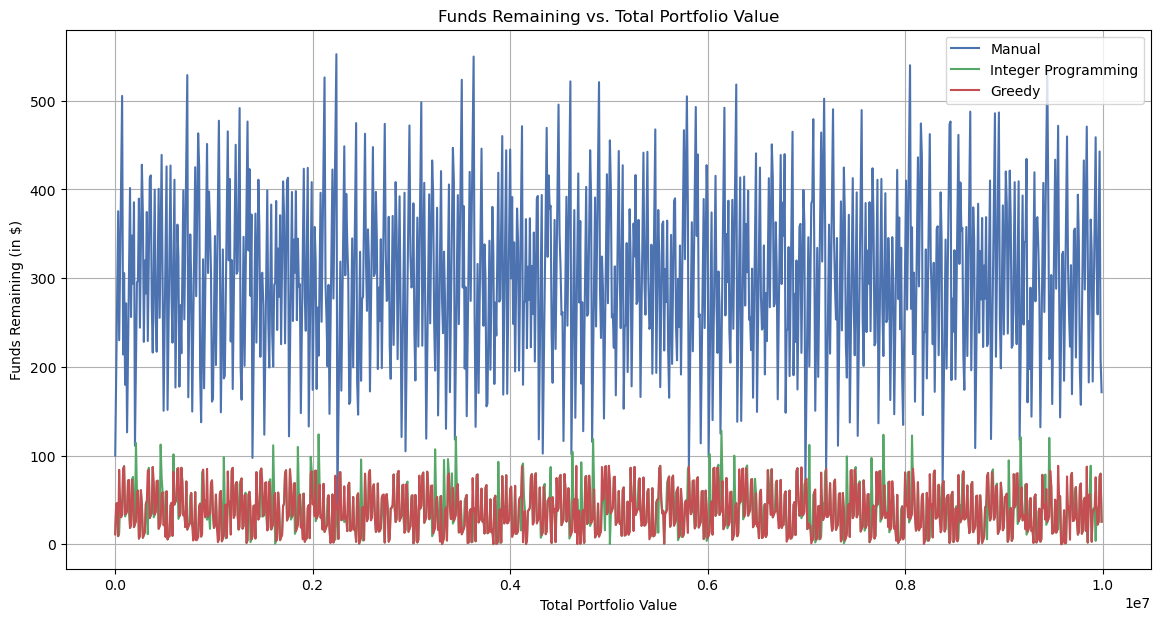

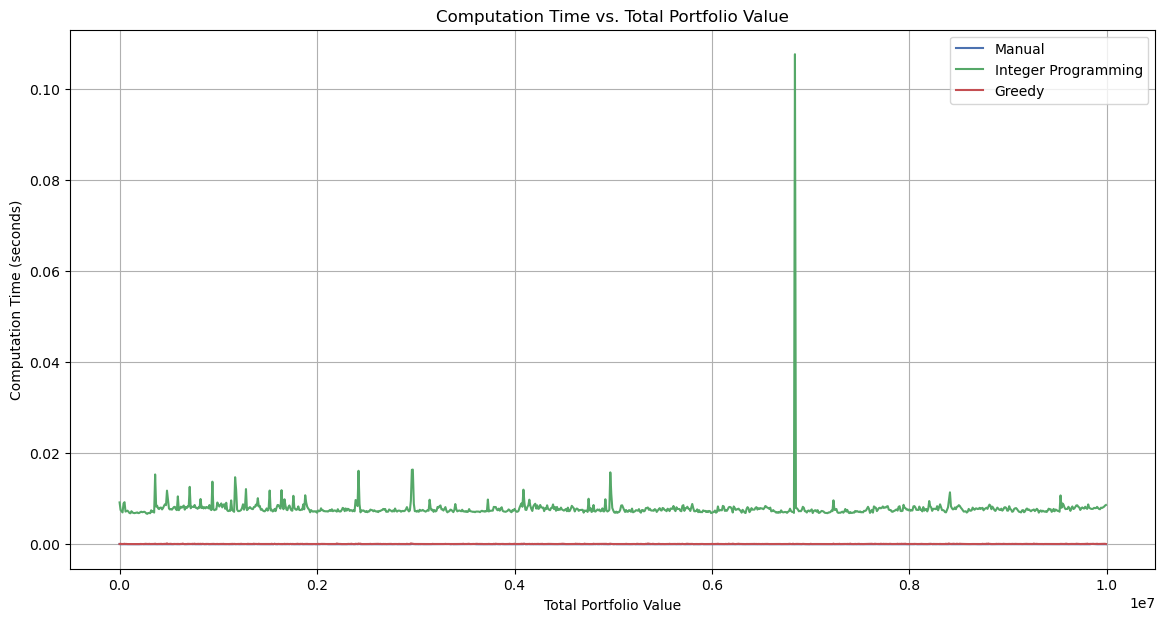

In [45]:
portfolio_values = range(100, 10000001, 10000)

manual_funds_remaining = []
integer_funds_remaining = []
greedy_funds_remaining = []

manual_comp_time = []
integer_comp_time = []
greedy_comp_time = []

for value in portfolio_values:
    _, funds, cp_time = manual_allocation(cleaned_weights, latest_prices, value)
    manual_funds_remaining.append(funds)
    manual_comp_time.append(cp_time)
    
    _, funds, cp_time = integer_programming_allocation(latest_prices, cleaned_weights, value)
    integer_funds_remaining.append(funds)
    integer_comp_time.append(cp_time)
    
    _, funds, cp_time = greedy_allocation_simulation(cleaned_weights, latest_prices, value)
    greedy_funds_remaining.append(funds)
    greedy_comp_time.append(cp_time)

plt.figure(figsize=(14, 7))
plt.plot(portfolio_values, manual_funds_remaining, label='Manual')
plt.plot(portfolio_values, integer_funds_remaining, label='Integer Programming')
plt.plot(portfolio_values, greedy_funds_remaining, label='Greedy')
plt.title('Funds Remaining vs. Total Portfolio Value')
plt.xlabel('Total Portfolio Value')
plt.ylabel('Funds Remaining (in $)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(portfolio_values, manual_comp_time, label='Manual')
plt.plot(portfolio_values, integer_comp_time, label='Integer Programming')
plt.plot(portfolio_values, greedy_comp_time, label='Greedy')
plt.title('Computation Time vs. Total Portfolio Value')
plt.xlabel('Total Portfolio Value')
plt.ylabel('Computation Time (seconds)')
plt.legend()
plt.grid(True)
plt.show()

Here, we plot for portfolio values ranging from \$10 to \$10 million.

Looking at the bigger picture, the greedy algorithm provides the best of both worlds. In fact, it seems to be on par with Integer programming (in terms of optimizing fund allocation), and the manual method (in terms of achieving fast computation times). 

It comes out on top but we are yet to test an important factor in portfolio optimization: it's market efectiveness against the original calculated portfolio return. We will test this in the next artifact.

## References

- PyPortfolioOpt. (2023). *PyPortfolioOpt Documentation*. [Online documentation]. Available at https://pyportfolioopt.readthedocs.io/en/latest/UserGuide.html (accessed on 14 Apr. 2024).

- OpenAI. ChatGPT [Software]. Available from https://openai.com/chatgpt